## Sentiment analaysis from financial news data for BYD and Tesla 

### Project Overview

1. **Data Source**:  
   - News headlines are scraped from [**Finviz**](https://finviz.com/), a popular financial news and stock screener platform.

2. **Key Libraries Used**:
   - `BeautifulSoup`: For parsing and extracting news headlines from HTML (web scraping).
   - `urllib.request.Request`: For making HTTP requests to retrieve webpage content.
   - `nltk (VADER)`: For performing sentiment analysis on news headlines.

3. **Notebook Outcome**:
   - Generates visualizations that show **sentiment score patterns over time** for selected tech company stocks using heatmaps, and interactive line plots.

---

**Methodoloy**
- Market news is scraped from **Finviz** ([weblink](https://finviz.com/)) for selected stock tickers (`BYD` and `TSLA`) 
- Each news **headline** is analyzed using **VADER sentiment analysis** to generate a **compound sentiment score** (ranging from -1 to 1).
- Sentiment scores are aggregated **daily** for each ticker to reflect overall market sentiment.
- Results are visualized through **heatmaps**, and **interactive line plots** to reveal sentiment trends over time.
- Users can **hover over data points** in the interactive chart to explore daily sentiment and cross-reference with corresponding news headlines.


### 1. Import important libraries

In [68]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Download `vader_lexicon` which is a SentimentIntensityAnalyzer
nltk.download('vader_lexicon', quiet=True)

True

### 2. Scrape News Headlines from Finviz

This section loops through a list of stock tickers, constructs their corresponding Finviz URLs, and scrapes the latest news headlines.


In [70]:
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['TSLA', 'BYD']

news_tables = {}
for ticker in tickers:
    # Construct the URL for each ticker
    url = finviz_url + ticker
    req = Request(url, headers={'User-Agent': 'my-app'})
    
    try:
        response = urlopen(req) #fetch the page
        html = BeautifulSoup(response, 'html.parser') #parse the HTML
        news_table = html.find(id='news-table') # find the news table

        if news_table:
            news_tables[ticker] = news_table
        else:
            print(f"Warning: No news table found for {ticker}")

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}") #handle errors

### 3. Parse News Headlines and Build DataFrame
This section extracts structured information (ticker, date, time, title) from the HTML news tables.

In [72]:
#Parse the news data
parsed_data = [] #Initialize an empty list to store parsed data
for ticker, news_table in news_tables.items():
    for row in news_table.findAll('tr'):
        try:
            title = row.a.get_text() if row.a else None #Extracts tile
            date_data = row.td.text.split() if row.td else []#Extracts date and time
            
            if len(date_data) == 1:
                date = None
                time = date_data[0]
            elif len(date_data) == 2:
                date = date_data[0]
                time = date_data[1]
            else:
                continue
            if title:
                parsed_data.append([ticker, date, time, title])
        except Exception as e:
            print(f"Error parsing row: {e}")
            
# Create a DataFrame from the parsed data
df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])

In [73]:
#Check the number of missing values
missing_dates_by_ticker = df[df['date'].isna()]['ticker'].value_counts()
missing_dates_by_ticker

ticker
TSLA    95
BYD     31
Name: count, dtype: int64

### 4. Perform Sentiment Analysis and Prepare Data

In [121]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()
df['compound'] = df['title'].apply(lambda x: vader.polarity_scores(x)['compound'])

# Specify the format if known: 'Apr-19-25' => '%b-%d-%y'
df['date'] = pd.to_datetime(df['date'], format='%b-%d-%y', errors='coerce').dt.date
numeric_df = df[['ticker', 'date', 'compound']]


### 5. Visualize Sentiment Analysis Results

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Group and average sentiment by ticker and date
mean_df = numeric_df.groupby(['ticker', 'date']).mean().reset_index()
pivot_df = mean_df.pivot(index='date', columns='ticker', values='compound')

In [127]:
# plt.figure(figsize=(10, 6))
# sns.heatmap(pivot_df.T, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
# plt.title("Heatmap: Average Daily Sentiment Score")
# plt.xlabel("Date")
# plt.ylabel("Ticker")
# plt.tight_layout()
# plt.show()

**Interactive plot**


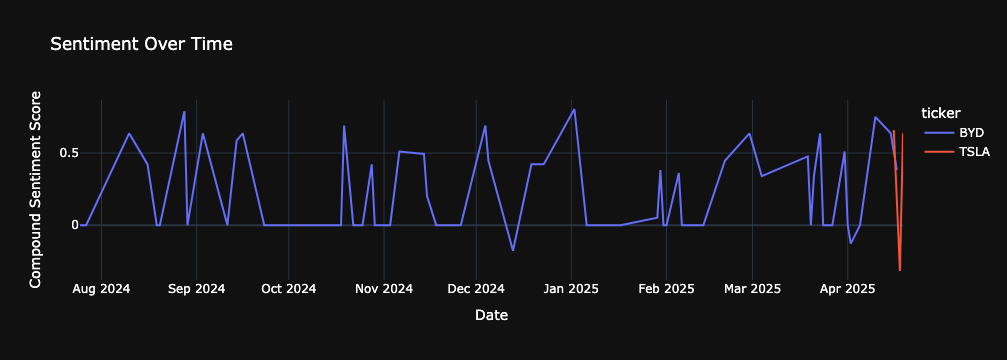

In [119]:
fig = px.line(mean_df, x='date', y='compound', color='ticker',
              title="Sentiment Over Time",
              labels={'compound': 'Compound Sentiment Score', 'date': 'Date'})
fig.update_layout(hovermode='x unified',  template='plotly_dark', font=dict(color='white'))
fig.show()


Hover over a data point to view sentiment details, then refer to the corresponding date to explore related news headlines from that day.

### Summary: 
- In market BYD has positive sentiment more often than TSLA. 

  